In [1]:
import os.path as osp
import sys
from pathlib import Path
import matplotlib.pyplot as plt

root_path = Path(osp.abspath("")).parents[1]
sys.path.append(str(root_path))

%config InlineBackend.figure_format='retina'

In [2]:
import numpy as np
from core.curve import BSpline
from utils import normalize

## B样条过渡

### 关于 Theorem 1

曲线 $B_0,B_1,B_2,B_3$ 有什么区别？

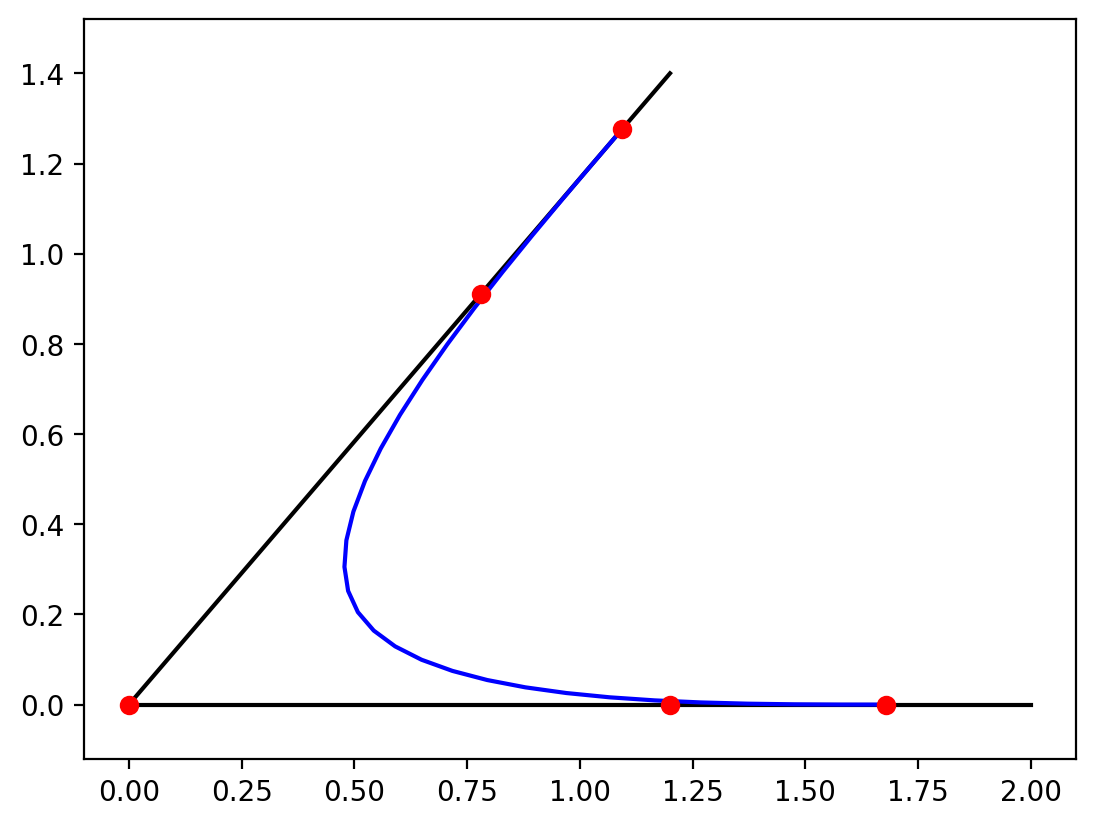

In [34]:
def get_B0_ctrpts(P0, P1, P2, c, d2):
    dir1 = normalize(P0 - P1)
    dir2 = normalize(P2 - P1)
    Q = np.zeros((5, 2))
    Q[0] = P1 + (1 + c) * d2 * dir1
    Q[1] = P1 + d2 * dir1
    Q[2] = P1
    Q[3] = P1 + d2 * dir2
    Q[4] = P1 + (1 + c) * d2 * dir2
    return Q


P0 = np.array([1.2, 1.4])
P1 = np.array([0, 0])
P2 = np.array([2, 0])
c = 0.4
d2 = 1.2
n_points = 30

knots0 = [0, 0, 0, 0, 0.5, 1, 1, 1, 1]
Q0 = get_B0_ctrpts(P0, P1, P2, c, d2)

B0 = BSpline(Q0, 3, knots0)

pts = B0.get_points(n_points)
# plot P0P1
plt.plot([P0[0], P1[0]], [P0[1], P1[1]], "k")
plt.plot([P1[0], P2[0]], [P1[1], P2[1]], "k")
# plot bspline
plt.plot(pts[:, 0], pts[:, 1], "b")
plt.plot(Q0[:, 0], Q0[:, 1], "ro")
plt.axis("equal")
plt.show()

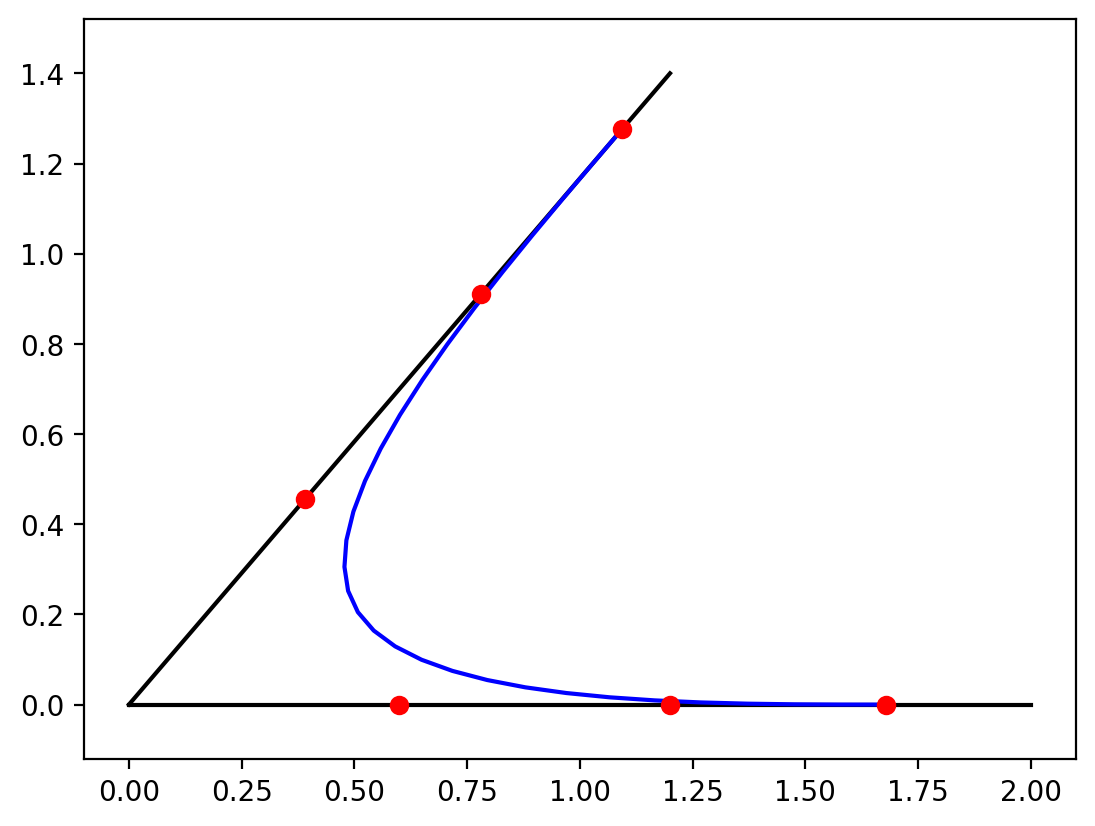

In [35]:
def get_B1_ctrpts(Q0):
    Q = np.zeros((6, 2))
    Q[0] = Q0[0]
    Q[1] = Q0[1]
    Q[2] = (Q0[1] + Q0[2]) / 2
    Q[3] = (Q0[2] + Q0[3]) / 2
    Q[4] = Q0[3]
    Q[5] = Q0[4]
    return Q


Q1 = get_B1_ctrpts(Q0)
knots1 = [0, 0, 0, 0, 0.5, 0.5, 1, 1, 1, 1]
B1 = BSpline(Q1, 3, knots1)
pts1 = B1.get_points(n_points)
# plot P0P1
plt.plot([P0[0], P1[0]], [P0[1], P1[1]], "k")
plt.plot([P1[0], P2[0]], [P1[1], P2[1]], "k")
# plot bspline
plt.plot(pts1[:, 0], pts1[:, 1], "b")
plt.plot(Q1[:, 0], Q1[:, 1], "ro")
plt.axis("equal")
plt.show()

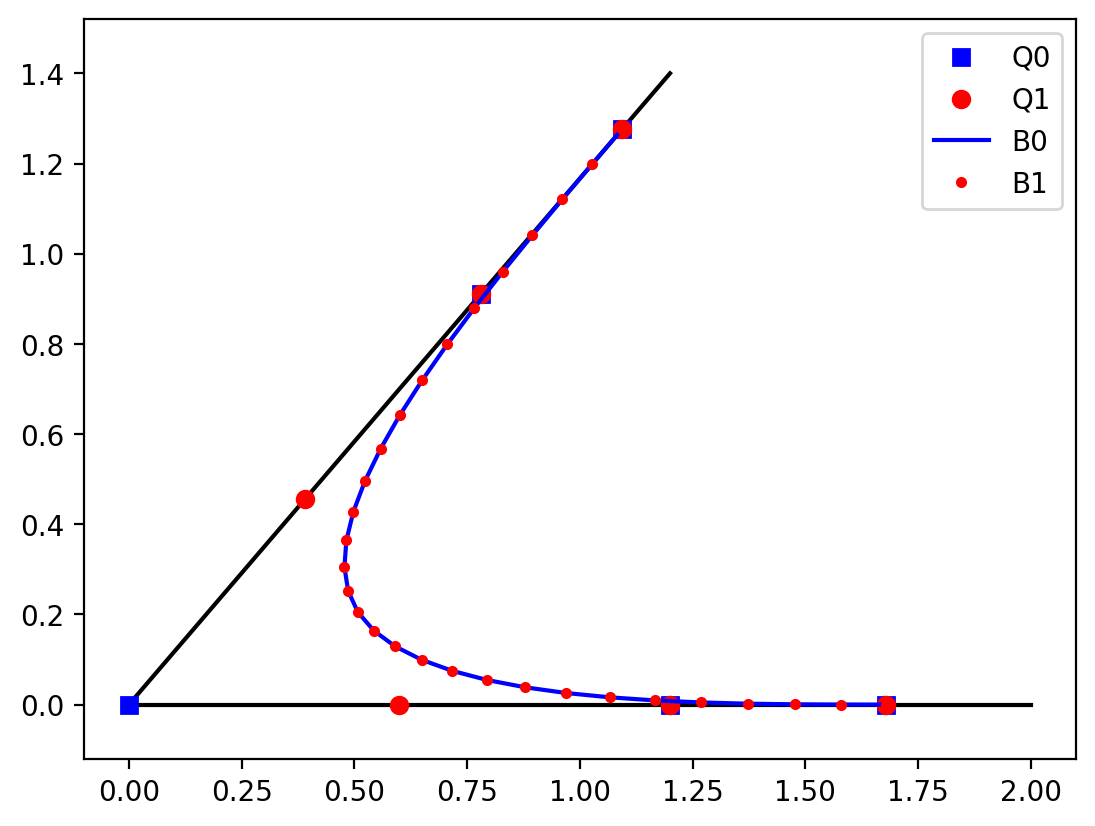

In [36]:
plt.plot([P0[0], P1[0]], [P0[1], P1[1]], "k")
plt.plot([P1[0], P2[0]], [P1[1], P2[1]], "k")

plt.plot(Q0[:, 0], Q0[:, 1], "bs", label="Q0")
plt.plot(Q1[:, 0], Q1[:, 1], "ro", label="Q1")


# plot bspline
plt.plot(pts[:, 0], pts[:, 1], "b", label="B0")
plt.plot(pts1[:, 0], pts1[:, 1], ".r", label="B1")
plt.axis("equal")
plt.legend()
plt.show()

可见 $B_0$ 和 $B_1$ 是相同的。

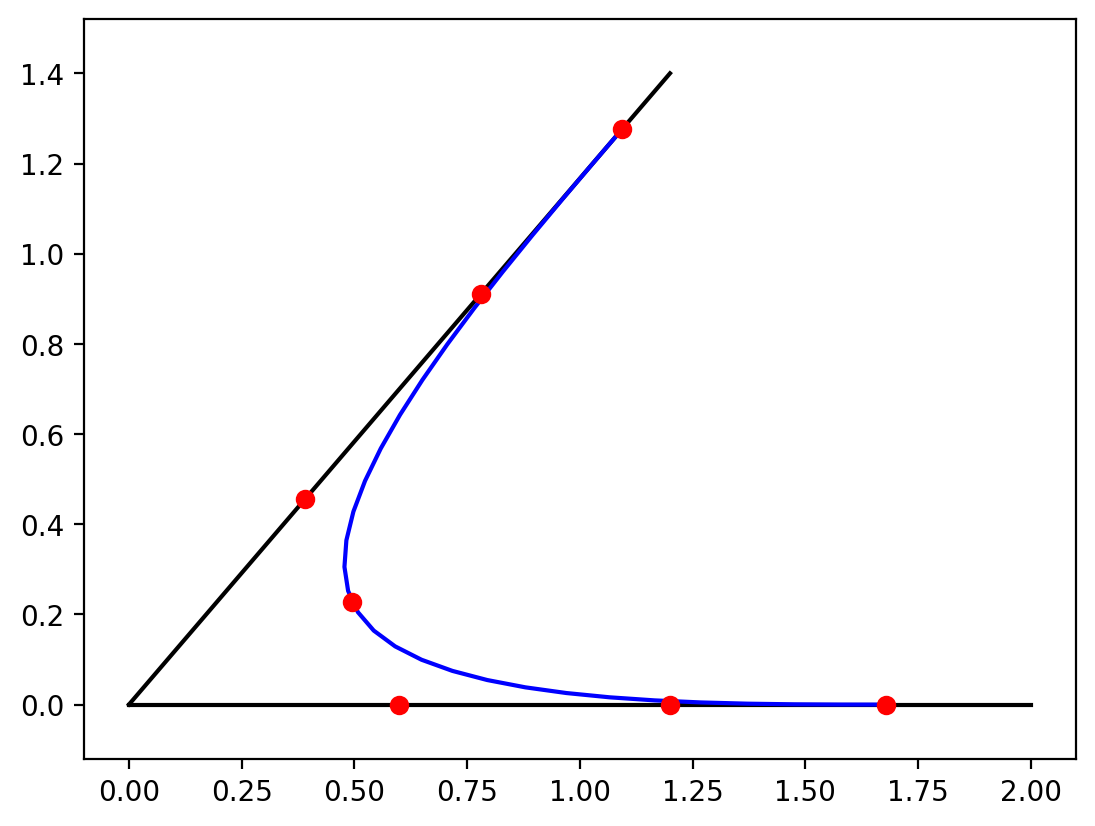

In [37]:
def get_B2_ctrpts(Q0, Q1):
    Q = np.zeros((7, 2))
    Q[0] = Q0[0]
    Q[1] = Q0[1]
    Q[2] = Q1[2]
    Q[4] = Q1[3]
    Q[5] = Q0[3]
    Q[6] = Q0[4]
    Q[3] = (Q[2] + Q[4]) / 2
    return Q


Q2 = get_B2_ctrpts(Q0, Q1)
knots2 = [0, 0, 0, 0, 0.5, 0.5, 0.5, 1, 1, 1, 1]
B2 = BSpline(Q2, 3, knots2)
pts2 = B2.get_points(n_points)
# plot P0P1
plt.plot([P0[0], P1[0]], [P0[1], P1[1]], "k")
plt.plot([P1[0], P2[0]], [P1[1], P2[1]], "k")
# plot bspline
plt.plot(pts2[:, 0], pts2[:, 1], "b")
plt.plot(Q2[:, 0], Q2[:, 1], "ro")
plt.axis("equal")
plt.show()

In [38]:
err0 = np.linalg.norm(pts - pts1)
err1 = np.linalg.norm(pts1 - pts2)
print(err0, err1)

6.544668208791957e-16 5.057306561942087e-16


可见 $B_1,B_2$ 和 $B_3$ 是相同的。

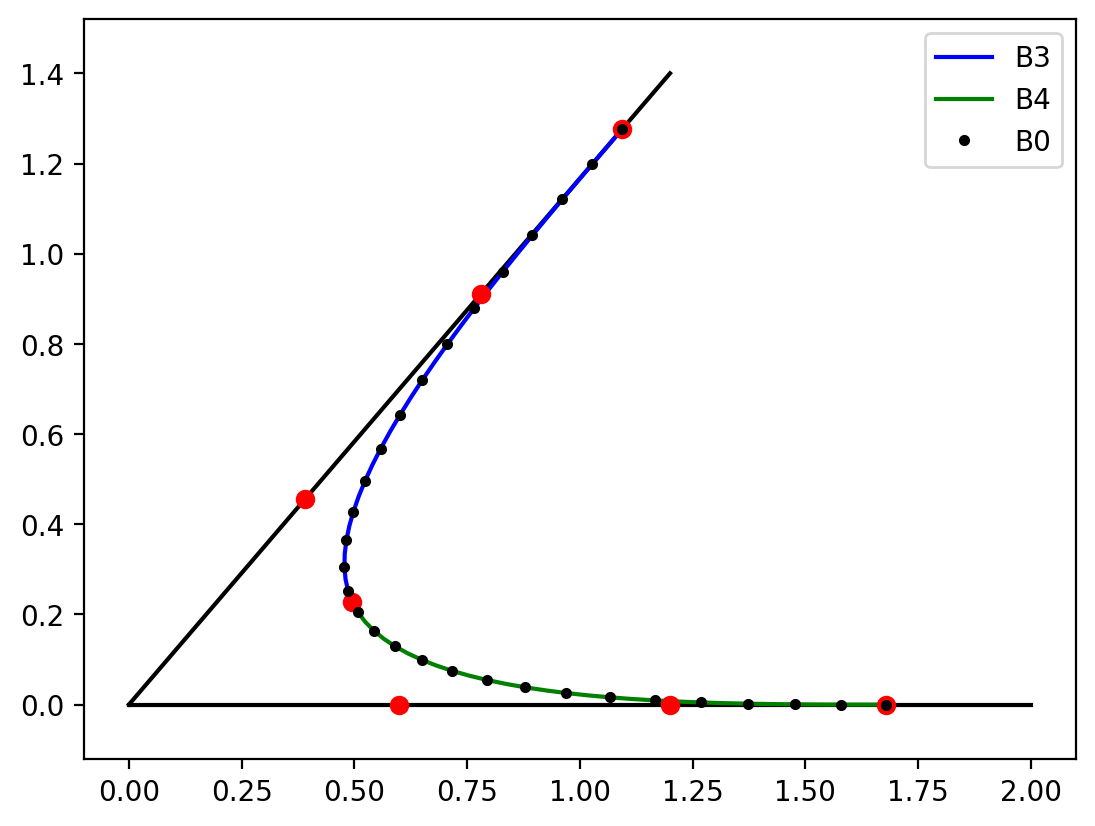

In [44]:
from core.curve import Bezier


def get_B3_ctrpts(Q2):
    return Q2[:4]


def get_B4_ctrpts(Q2):
    return Q2[3:]


Q3 = get_B3_ctrpts(Q2)
Q4 = get_B4_ctrpts(Q2)

B3 = Bezier(Q3)
B4 = Bezier(Q4)


# plot P0P1
plt.plot([P0[0], P1[0]], [P0[1], P1[1]], "k")
plt.plot([P1[0], P2[0]], [P1[1], P2[1]], "k")
# plot bezier
pts3 = B3.get_points(n_points)
pts4 = B4.get_points(n_points)
plt.plot(pts3[:, 0], pts3[:, 1], "b", label="B3")
plt.plot(pts4[:, 0], pts4[:, 1], "g", label="B4")
plt.plot(Q2[:, 0], Q2[:, 1], "ro")
plt.plot(pts[:, 0], pts[:, 1], "k.", label="B0")
plt.axis("equal")
plt.legend()
plt.show()

### 验证曲率

$$
\kappa = \frac{4\sin \beta}{3 d_2 \cos^2 \beta}
$$


In [45]:
dir1 = normalize(P0 - P1)
dir2 = normalize(P2 - P1)
theta = np.arccos(np.dot(dir1, dir2))
beta = (np.pi - theta) / 2
kappa = 4 * np.sin(beta) / (3 * d2 * np.cos(beta) ** 2)
curvature = B0.curvature(0.5)
print(kappa, curvature)

5.781408014420566 5.781408014420567
